In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import sklearn as skl
import sklearn.model_selection as skl_ms
import seaborn as sns
import cv2
from PIL import Image
import tensorflow_addons as tfa

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

tfk = tf.keras
tfkl = tf.keras.layers

In [3]:
dataframe = pd.read_csv('/kaggle/input/quality-annotated-dataframe/quality_annotated_dataframe.csv')

In [9]:
dataframe_quality = dataframe[dataframe['quality'] == 0]

filenames = dataframe_quality['file'].to_numpy()
to_remove = np.zeros(filenames.shape[0])

num_duplicates = 0

# Let's remove duplicates
for index in range(filenames.shape[0]):
    # Ignore the last element
    if index == filenames.shape[0] - 1:
        break
    
    filename = filenames[index]
    next_filename = filenames[index + 1]
    
    # Remove extension
    filename = filename.replace('.png', '')
    filename = filename.replace('.jpeg', '')
    next_filename = next_filename.replace('.png', '')
    next_filename = next_filename.replace('.jpeg', '')
    
    # If consecutive filenames refer to the same patient
    if filename[:-2] == next_filename[:-2]:
        to_remove[index + 1] = 1
        num_duplicates = num_duplicates + 1
        index = index + 1
        
dataframe_quality = dataframe_quality[to_remove == 0]
        
print('Removed %d duplicates' % num_duplicates)

dataframe_path = dataframe_quality.copy()
dataframe_path['path'] = '/kaggle/input/training-dataset/train/' + dataframe_path['label'] + '/' + dataframe_path['file']

Removed 1293 duplicates


In [10]:
dataframe_path["path"]

1        /kaggle/input/training-dataset/train/N/P00001_...
2        /kaggle/input/training-dataset/train/N/P00002_...
3        /kaggle/input/training-dataset/train/N/P00003_...
4        /kaggle/input/training-dataset/train/N/P00004_...
5        /kaggle/input/training-dataset/train/T/P00005_...
                               ...                        
15463    /kaggle/input/training-dataset/train/P/P16109_...
15464    /kaggle/input/training-dataset/train/T/P16110_...
15466    /kaggle/input/training-dataset/train/N/P16112_...
15468    /kaggle/input/training-dataset/train/T/P16114_...
15469    /kaggle/input/training-dataset/train/N/P16115_...
Name: path, Length: 10792, dtype: object

In [11]:
seed = 595126
train_path_based, test_path_based = train_test_split(dataframe_path, random_state = seed, test_size=0.2, shuffle=True)
train_path_based, validation_path_based = train_test_split(train_path_based, random_state=seed, test_size=0.1, shuffle=True)

In [12]:
def preprocessing(image):
    if image.shape[-1] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    image = np.uint8(image)

    # Check if background is Standard Radiological Format compliant, otherwise invert colors
    # (the check is performed on the median color along the spine)
    buffer = image / np.max(image)

    median_spine = np.median(buffer[:, buffer.shape[1] // 2])

    if median_spine < 0.5:
        image = cv2.bitwise_not(image)

    # Mist reduction and gamma transformation
    img_equalized = cv2.equalizeHist(image)
    gamma = 1.5
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255
                    for i in np.arange(0, 256)]).astype('uint8')
    img_gamma = cv2.LUT(img_equalized, table)

    # Apply Adaptive Contrast Equalization
    clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(8,8))
    clahe_img = clahe.apply(img_gamma)

    # Apply Gaussian Smoothing
    gaussian_img = cv2.GaussianBlur(clahe_img, (5,5), 0)

    gaussian_img = gaussian_img.reshape(gaussian_img.shape[0], gaussian_img.shape[1], 1)

    # Rescale to float between 0 and 1
    rescaled = np.float32(gaussian_img) / 255.

    return rescaled

In [13]:
root_dir = '/kaggle/input/normalpneumoniatubeculosis-qualityannotated'

# Create an ImageDataGenerator object to preprocess the images
train_datagen = ImageDataGenerator(preprocessing_function=preprocessing)
# Use flow_from_dataframe method to read images from directory based on dataframe
train_generator = train_datagen.flow_from_dataframe(
    color_mode = 'grayscale',
    dataframe=train_path_based,
    directory=root_dir,
    x_col='path',
    y_col='label',
    target_size=(512, 512), # set the target image size
    batch_size=64, # set the batch size
    class_mode='categorical' # set the class mode to categorical for multi-class classification
)


validation_datagen = ImageDataGenerator(preprocessing_function=preprocessing)

# Use flow_from_dataframe method to read images from directory based on dataframe
validation_generator = validation_datagen.flow_from_dataframe(
    color_mode = 'grayscale',
    dataframe=validation_path_based,
    directory=root_dir,
    x_col='path',
    y_col='label',
    shuffle = False,
    target_size=(512, 512), # set the target image size
    batch_size=64, # set the batch size
    class_mode='categorical' # set the class mode to categorical for multi-class classification
)


test_datagen = ImageDataGenerator(preprocessing_function=preprocessing)

# Use flow_from_dataframe method to read images from directory based on dataframe
test_generator = test_datagen.flow_from_dataframe(
    color_mode = 'grayscale',
    dataframe=test_path_based,
    directory=root_dir,
    x_col='path',
    y_col='label',
    shuffle = False,
    target_size=(512, 512), # set the target image size
    batch_size=64, # set the batch size
    class_mode='categorical' # set the class mode to categorical for multi-class classification
)

Found 7769 validated image filenames belonging to 3 classes.
Found 864 validated image filenames belonging to 3 classes.
Found 2159 validated image filenames belonging to 3 classes.


In [14]:
def CNN2_model(input_shape):
    activation = 'swish'

    current_model = tfk.Sequential()
    current_model.add(tfkl.InputLayer(input_shape=input_shape, name='input_layer'))
    current_model.add(tfkl.Conv2D(filters=32, kernel_size=3, strides=(1,1),
                              padding='same', activation = activation))
    current_model.add(tfkl.MaxPool2D())
    current_model.add(tfkl.Conv2D(filters=64, kernel_size=3, strides=(1,1),
                              padding='same', activation = activation))
    current_model.add(tfkl.MaxPool2D())
    current_model.add(tfkl.Conv2D(filters=128, kernel_size=3, strides=(1,1),
                              padding='same', activation = activation))
    current_model.add(tfkl.MaxPool2D())
    current_model.add(tfkl.Conv2D(filters=256, kernel_size=3, strides=(1,1),
                              padding='same', activation = activation))
    current_model.add(tfkl.MaxPool2D())
    current_model.add(tfkl.Conv2D(filters=512, kernel_size=3, strides=(1,1),
                              padding='same', activation = activation))
    current_model.add(tfkl.Conv2D(filters=512, kernel_size=3, strides=(1,1),
                              padding='same', activation = activation))
    current_model.add(tfkl.MaxPool2D())
    current_model.add(tfkl.Conv2D(filters=3, kernel_size=1, strides=(1,1),
                              padding='same', activation = activation))
    current_model.add(tfkl.GlobalAveragePooling2D())
    current_model.add(tfkl.Activation(activation='softmax'))

    # Compile the model
    current_model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                    optimizer=tfk.optimizers.Adam(1e-3),
                    metrics=['accuracy'])

    return current_model

In [15]:
CNN_model = CNN2_model((512,512,1))
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 512, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 128)      0

In [16]:
history_CNN = CNN_model.fit(
    x = train_generator,
    batch_size = 64,
    epochs = 30,
    class_weight = {0: 0.95, 1: 1.0, 2: 1.4},
    validation_data = validation_generator,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)]
).history

Epoch 1/30
122/122 [==============================] - 223s 2s/step - loss: 1.0142 - accuracy: 0.5994 - val_loss: 0.8890 - val_accuracy: 0.6296
Epoch 2/30
122/122 [==============================] - 162s 1s/step - loss: 0.9866 - accuracy: 0.6109 - val_loss: 0.8519 - val_accuracy: 0.7269
Epoch 3/30
122/122 [==============================] - 163s 1s/step - loss: 0.9377 - accuracy: 0.6463 - val_loss: 0.7545 - val_accuracy: 0.7269
Epoch 4/30
122/122 [==============================] - 162s 1s/step - loss: 0.7474 - accuracy: 0.7383 - val_loss: 0.6124 - val_accuracy: 0.7917
Epoch 5/30
122/122 [==============================] - 162s 1s/step - loss: 0.6857 - accuracy: 0.7633 - val_loss: 0.5559 - val_accuracy: 0.8044
Epoch 6/30
122/122 [==============================] - 162s 1s/step - loss: 0.6218 - accuracy: 0.7811 - val_loss: 0.5290 - val_accuracy: 0.8032
Epoch 7/30
122/122 [==============================] - 160s 1s/step - loss: 0.5942 - accuracy: 0.7933 - val_loss: 0.5216 - val_accuracy: 0.7975

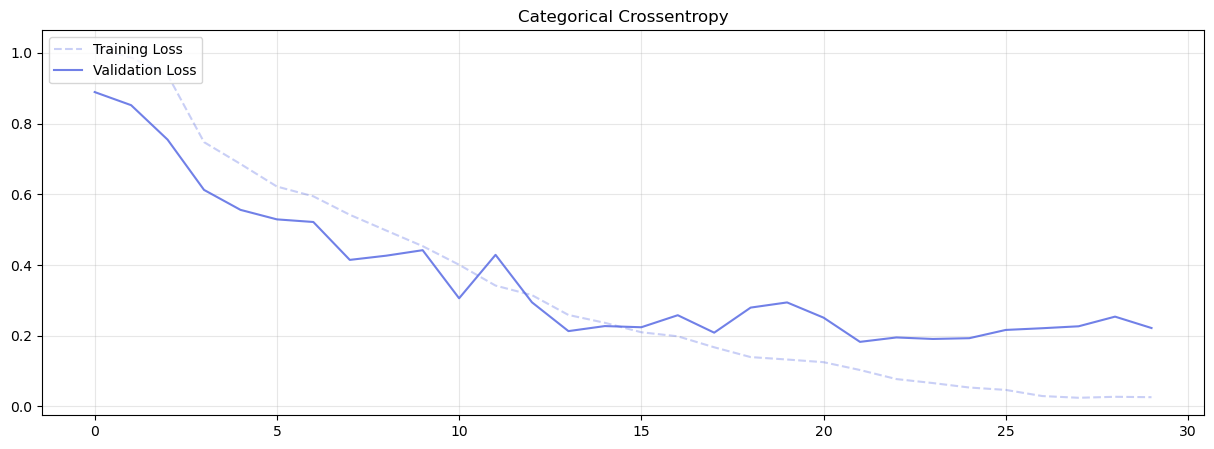

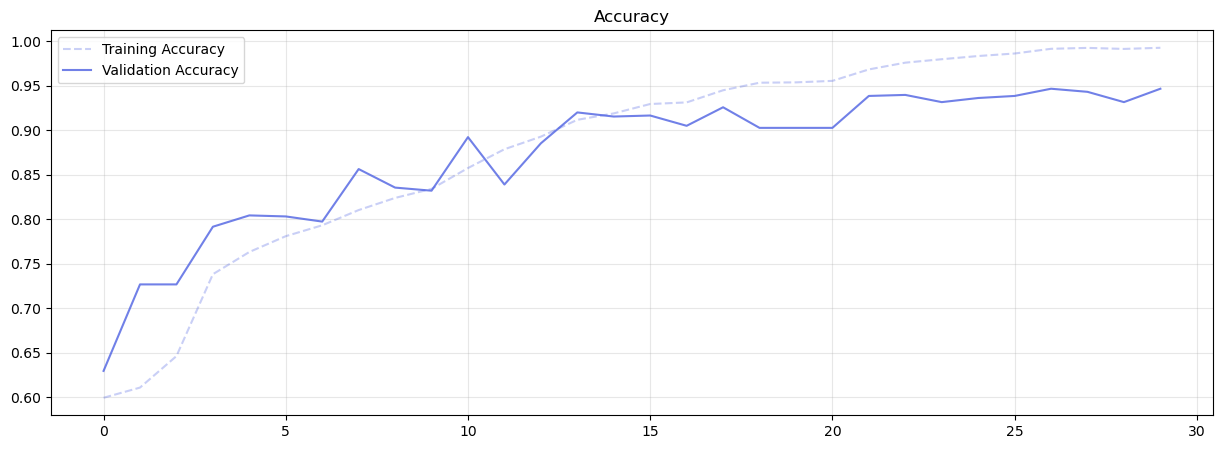

In [17]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history_CNN['loss'], label='Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_CNN['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history_CNN['accuracy'], label = 'Training Accuracy', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_CNN['val_accuracy'], label='Validation Accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [19]:
# Predict the test set with the CNN1
predictions = CNN_model.predict(test_generator)
label_names = {
    0: "N",
    1: "P",
    2: "T"
}
label_classes = label_names.values()
converted_test_labels = np.zeros(test_path_based["label"].shape)
converted_test_labels[test_path_based["label"] == 'N'] = 0
converted_test_labels[test_path_based["label"] == 'P'] = 1
converted_test_labels[test_path_based["label"] == 'T'] = 2 

34/34 [==============================] - 38s 1s/step


Accuracy: 0.9333
Precision: 0.9234
Recall: 0.8882
F1: 0.9037


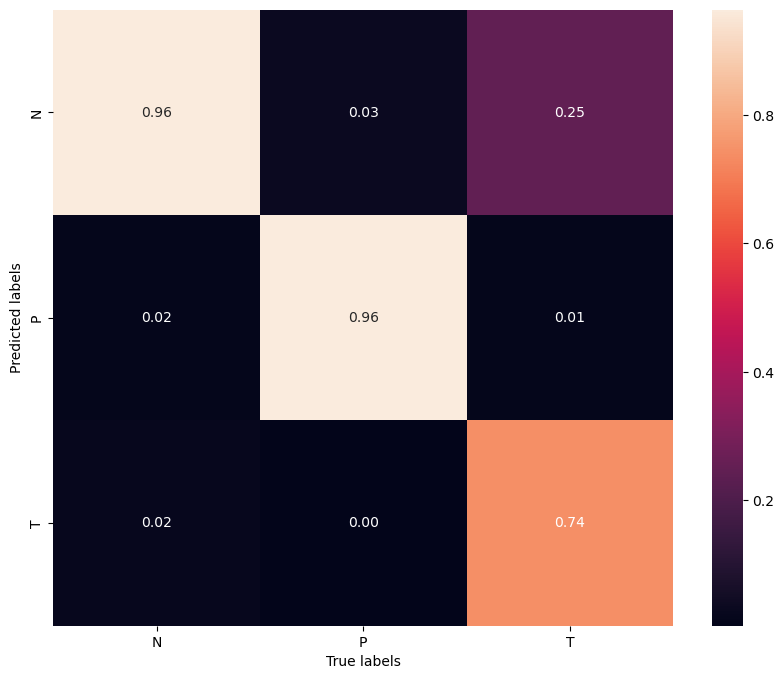

In [20]:
# Compute the confusion matrix
cm = confusion_matrix(converted_test_labels, np.argmax(predictions, axis=-1))
cm_rel = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Compute the classification metrics
accuracy = accuracy_score(converted_test_labels, np.argmax(predictions, axis=-1))
precision = precision_score(converted_test_labels, np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(converted_test_labels, np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(converted_test_labels, np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm_rel.T, xticklabels=label_classes, yticklabels=label_classes, annot=True, fmt='.2f')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [21]:
prediction_numerical = np.argmax(predictions, axis=-1)

In [22]:
from sklearn.metrics import classification_report
# generate the classification report
print(classification_report(converted_test_labels, prediction_numerical, target_names=['Normal', 'Pneumonia', 'Tuberculosis']))

              precision    recall  f1-score   support

      Normal       0.93      0.96      0.95      1264
   Pneumonia       0.96      0.96      0.96       610
Tuberculosis       0.88      0.74      0.80       285

    accuracy                           0.93      2159
   macro avg       0.92      0.89      0.90      2159
weighted avg       0.93      0.93      0.93      2159



In [23]:
CNN_model.save('Scratch-withoutAug')

In [24]:
!zip -r Scratch-withoutAug.zip /kaggle/working/Scratch-withoutAug -r 

  adding: kaggle/working/Scratch-withoutAug/ (stored 0%)
  adding: kaggle/working/Scratch-withoutAug/keras_metadata.pb (deflated 93%)
  adding: kaggle/working/Scratch-withoutAug/variables/ (stored 0%)
  adding: kaggle/working/Scratch-withoutAug/variables/variables.index (deflated 66%)
  adding: kaggle/working/Scratch-withoutAug/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: kaggle/working/Scratch-withoutAug/saved_model.pb (deflated 90%)
  adding: kaggle/working/Scratch-withoutAug/assets/ (stored 0%)
  adding: kaggle/working/Scratch-withoutAug/fingerprint.pb (stored 0%)
